# Katakana classifier

## Import

In [1]:
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "notebook"

import optuna

In [2]:
%load_ext autoreload
%autoreload 2
# from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.activations import *
from common.optimizer import Adam

In [3]:
%load_ext autoreload
%autoreload 2
from common.model import Conv2DNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print('pandas: ', pd.__version__)

pandas:  1.5.1


In [5]:
def onehot_to_str(label):
    """
    ワンホットベクトル形式のラベルをカタカナ文字に変換する
    """
    dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}
    label_int = np.argmax(label)
    for key, value in dic_katakana.items():
        if value==label_int:
            return key

## Read data

In [6]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [7]:
# value counts
unique, counts = np.unique(np.argmax(train_label, axis=1), return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 200]
 [  1 200]
 [  2 200]
 [  3 200]
 [  4 200]
 [  5 200]
 [  6 200]
 [  7 200]
 [  8 200]
 [  9 200]
 [ 10 200]
 [ 11 200]
 [ 12 200]
 [ 13 200]
 [ 14 200]]


se


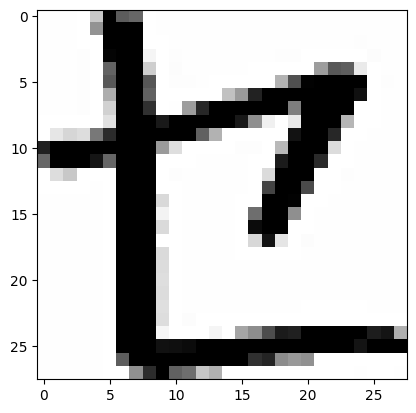

In [8]:
index = 10
print( onehot_to_str(train_label[index]) )
plt.imshow(train_data[index][0], cmap='gray')

2761 ko


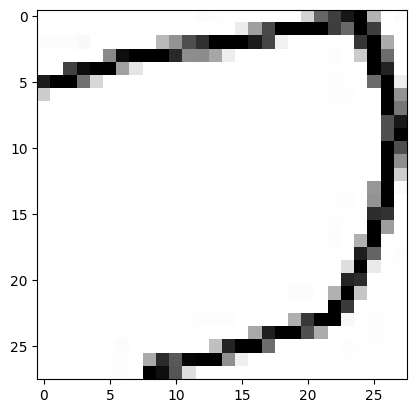

In [9]:
index = np.random.randint(train_label.shape[0], size=1)[0]
print(index,  onehot_to_str(train_label[index]) )
plt.imshow(train_data[index][0], cmap='gray')

In [10]:
print(train_data.min(), train_data.max())

0.0 255.0


## FE

In [11]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [12]:
# # 配列形式変更
# train_data = train_data.reshape(-1, 28*28)
# print("train_data.shape=", train_data.shape)

## Split

### ImageDataGenerator

In [13]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [14]:
# datagen = ImageDataGenerator(
#     featurewise_center=True, # 真理値．データセット全体で，入力の平均を0にします
#     featurewise_std_normalization=True, # 真理値．入力をデータセットの標準偏差で正規化します
#     rotation_range=20, # 整数．画像をランダムに回転する回転範囲
#     width_shift_range=0.2, # 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲
#     height_shift_range=0.2, # 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲
#     horizontal_flip=False, # 真理値．水平方向に入力をランダムに反転します
# )

# datagen.fit(train_data, seed=42)

# # fits the model on batches with real-time data augmentation:
# g = datagen.flow(train_data, train_label, batch_size=train_label.shape[0], seed=42)

In [15]:
# x, y = g.next()
# print(x.shape, y.shape)
# index = 10
# print( onehot_to_str(y[index]) )
# plt.imshow(x[index][0], cmap='gray')

In [16]:
# train_data_reshaped = train_data.reshape(train_data.shape[0], 28, 28, 1)
# print('train_data_reshaped:', train_data_reshaped.shape)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2, shuffle=True, random_state=42, stratify=train_label)
print('X_train:', X_train.shape, ', X_test:', X_test.shape)

X_train: (2400, 1, 28, 28) , X_test: (600, 1, 28, 28)


In [18]:
datagen = ImageDataGenerator(
    featurewise_center=True, # 真理値．データセット全体で，入力の平均を0にします
    featurewise_std_normalization=True, # 真理値．入力をデータセットの標準偏差で正規化します
    rotation_range=20, # 整数．画像をランダムに回転する回転範囲
    width_shift_range=0.2, # 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲
    height_shift_range=0.2, # 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲
    horizontal_flip=False, # 真理値．水平方向に入力をランダムに反転します
)

datagen.fit(X_train, seed=42)

# fits the model on batches with real-time data augmentation:
g = datagen.flow(X_train, y_train, batch_size=train_label.shape[0], seed=42)

/home/eunchong/.local/lib/python3.8/site-packages/keras/preprocessing/image.py:1874: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  warnings.warn('Expected input to be images (as Numpy array) '
/home/eunchong/.local/lib/python3.8/site-packages/keras/preprocessing/image.py:680: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


In [19]:
for i in range(3):
    x, y = g.next()
    X_train = np.append(X_train, x, axis=0)
    y_train = np.append(y_train, y, axis=0)
print(X_train.shape)

(9600, 1, 28, 28)


In [20]:
# value counts
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 640]
 [  1 640]
 [  2 640]
 [  3 640]
 [  4 640]
 [  5 640]
 [  6 640]
 [  7 640]
 [  8 640]
 [  9 640]
 [ 10 640]
 [ 11 640]
 [ 12 640]
 [ 13 640]
 [ 14 640]]


In [21]:
# value counts
unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 40]
 [ 1 40]
 [ 2 40]
 [ 3 40]
 [ 4 40]
 [ 5 40]
 [ 6 40]
 [ 7 40]
 [ 8 40]
 [ 9 40]
 [10 40]
 [11 40]
 [12 40]
 [13 40]
 [14 40]]


## Train

### early_stopping

In [22]:
def early_stopping(model, best_model, new_value, prev_value, patience_cnt, patience=2, direction='minimize'):
    stop_flg = False
    update_value = prev_value
    if direction == 'minimize':
        if new_value < prev_value:
            update_value = new_value
            best_model = copy.deepcopy(model)
            patience_cnt = 0
        else:
            patience_cnt += 1
            
    elif direction == 'maximize':
        if new_value > prev_value:
            update_value = new_value
            best_model = copy.deepcopy(model)
            patience_cnt = 0
        else:
            patience_cnt += 1
            
    if patience_cnt >= patience:
        stop_flg = True

    return update_value, patience_cnt, stop_flg, best_model

### train func

In [23]:
# def trainConv2DNN(X_train, y_train, quite=False, **kwargs):
def trainConv2DNN(X_train, y_train, X_test, y_test, quite=False, **kwargs):
    np.random.seed(42)
    
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=42)
    # print('X_train', X_train.shape, ', X_val', X_val.shape)
    
    X_val = X_test.copy()
    y_val = y_test.copy()

    epochs = kwargs['epochs']
    batch_size = kwargs['batch_size']

    optimizer = Adam(lr=kwargs['learning_rate'], epsilon=kwargs['epsilon'])

    # 繰り返し回数
    xsize = X_train.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    # CNNのオブジェクト生成
    model = Conv2DNN(
        input_dim=X_train.shape[1:], 
        weight_init_std=0.01,
        **kwargs
    )
    model.summary()

    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    # for early stopping
    prev_value = patience_cnt = 0
    best_model = None

    # for epoch in tqdm(range(epochs)):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        # print("epoch=%s"%epoch)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            # print("it=", it)
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            X_train_mini = X_train[mask]
            y_train_mini = y_train[mask]

            # 勾配の計算 (誤差逆伝播法を用いる) 
            grads = model.gradient(X_train_mini, y_train_mini, train_flg=True)

            # 更新
            optimizer.update(model.params, grads)

        ## 学習経過の記録
        # 訓練データにおけるloss
        train_loss_list.append(model.loss(X_train, y_train, train_flg=False))
        # テストデータにおけるloss
        val_loss_list.append(model.loss(X_val, y_val, train_flg=False))
        # 訓練データにて精度を確認
        train_accuracy_list.append(model.accuracy(X_train, y_train))
        # テストデータにて精度を算出
        val_accuracy_list.append(model.accuracy(X_val, y_val))
        
        # early_stopping
        prev_value, patience_cnt, stop_flg, best_model = early_stopping(
            model, best_model, val_accuracy_list[-1], prev_value, patience_cnt, patience=kwargs['patience'], direction='maximize'
        )
        if stop_flg:
            model = best_model
            break
            
        pbar.set_description(f'val_accuracy: {val_accuracy_list[-1]:.4}')
        
    history_df = pd.DataFrame({
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "train_accuracy": train_accuracy_list,
        "val_accuracy": val_accuracy_list,
    })
    if not quite:
        # lossのグラフ化
        display( history_df.tail(1) )
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        history_df.filter(regex='loss').plot(ax=ax1, grid=True, xlabel='epochs', ylabel='loss')
        history_df.filter(regex='accuracy').plot(ax=ax2, grid=True, xlabel='epochs', ylabel='accuracy', ylim=(0.9, 1.0))
        plt.show()

    return model, history_df

### test func

In [24]:
def testModel(model, X_test, y_test, quite=False):
    # loss
    accuracy = model.accuracy(X_test, y_test)
    loss  = model.loss(X_test, y_test, train_flg=False)

    if not quite:
        print(f'> loss: {loss:.4}, accuracy: {accuracy:.4}')
    
    return loss, accuracy

### try1

In [ ]:
%%time
layer_params = {
    'Conv1': {'channel': 64, 'size': 3, 'pad': 0, 'stride': 1},
    'ReLU1': {},
    'Conv2': {'channel': 64, 'size': 3, 'pad': 0, 'stride': 1},
    'ReLU2': {},
    'Pool1': {'size': 2, 'pad': 0, 'stride': 2},
    'BatchNorm1': {},
    # 'Dropout1': {'dropout': 0.1},
    'Conv3': {'channel': 128, 'size': 3, 'pad': 0, 'stride': 1},
    'ReLU3': {},
    'Conv4': {'channel': 128, 'size': 3, 'pad': 0, 'stride': 1},
    'ReLU4': {},
    'Pool2': {'size': 2, 'pad': 0, 'stride': 2},
    'BatchNorm2': {},
    # 'Dropout2': {'dropout': 0.1},
    'Conv5': {'channel': 256, 'size': 3, 'pad': 0, 'stride': 1},
    'ReLU5': {},
    'Pool3': {'size': 2, 'pad': 0, 'stride': 2},
    'BatchNorm3': {},
    # 'Dropout3': {'dropout': 0.1},
    'Flatten': {},
    'Affine1': {'hidden_size': 512},
    'ReLU6': {},
    # 'BatchNorm4': {},
    # 'Affine2': {'hidden_size': 128},
    # 'ReLU7': {},
    # 'BatchNorm5': {},
    'Affine3': {'hidden_size': 15},
}
hp_params = {
    'layer_params': layer_params,
    'learning_rate': 1e-3, 'epsilon': 1e-8, # Compile HP
    'batch_size': 32, 'epochs': 100, 'patience': 10, # fit HP
}
model, history_df = trainConv2DNN(X_train, y_train, X_test, y_test, **hp_params)
loss, accuracy = testModel(model, X_test, y_test)
loss, accuracy = testModel(model, train_data, train_label)

/tmp/ipykernel_1552/4264712211.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


Conv1		(None, 64, 26, 26)	640	(64, 1, 3, 3), (64,)
Conv2		(None, 64, 24, 24)	36928	(64, 64, 3, 3), (64,)
Pool1		(None, 64, 12, 12)
BatchNorm1	(None, 64, 12, 12)	256	(64,), (64,), (64,), (64,)
Conv3		(None, 128, 10, 10)	73856	(128, 64, 3, 3), (128,)
Conv4		(None, 128, 8, 8)	147584	(128, 128, 3, 3), (128,)
Pool2		(None, 128, 4, 4)
BatchNorm2	(None, 128, 4, 4)	512	(128,), (128,), (128,), (128,)
Conv5		(None, 256, 2, 2)	295168	(256, 128, 3, 3), (256,)
Pool3		(None, 256, 1, 1)
BatchNorm3	(None, 256, 1, 1)	1024	(256,), (256,), (256,), (256,)
Flatten		(None, 256)
Affine1		(None, 512)		131584	(256, 512), (512,)
Affine3		(None, 15)		7695	(512, 15), (15,)


  0%|                                                                                      | 0/100 [00:00<?, ?it/s]

### try2

In [20]:
# %%time
# layer_params = {
#     'Conv1': {'channel': 64, 'size': 3, 'pad': 0, 'stride': 1},
#     'ReLU1': {},
#     # 'Conv2': {'channel': 64, 'size': 3, 'pad': 0, 'stride': 1},
#     # 'ReLU2': {},
#     'Pool1': {'size': 2, 'pad': 0, 'stride': 2},
#     # 'BatchNorm1': {},
#     # 'Dropout1': {'dropout': 0.1},
#     # 'Conv3': {'channel': 128, 'size': 3, 'pad': 0, 'stride': 1},
#     # 'ReLU3': {},
#     # 'Conv4': {'channel': 128, 'size': 3, 'pad': 0, 'stride': 1},
#     # 'ReLU4': {},
#     # 'Pool2': {'size': 2, 'pad': 0, 'stride': 2},
#     # 'Conv5': {'channel': 256, 'size': 3, 'pad': 0, 'stride': 1},
#     # 'ReLU5': {},
#     # 'Pool3': {'size': 2, 'pad': 0, 'stride': 2},
#     # 'BatchNorm2': {},
#     # 'Dropout2': {'dropout': 0.1},
#     'Flatten': {},
#     'Affine1': {'hidden_size': 512},
#     'ReLU6': {},
#     'Affine2': {'hidden_size': 15},
#     'Softmax1': {},
# }
# hp_params = {
#     'layer_params': layer_params,
#     'learning_rate': 1e-3, 'epsilon': 1e-8, # Compile HP
#     'batch_size': 32, 'epochs': 0, 'patience': 4, # fit HP
# }
# model, history_df = trainConv2DNN(X_train, y_train, X_test, y_test, **hp_params)
# # loss, accuracy = testModel(model, X_test, y_test)
# # loss, accuracy = testModel(model, train_data, train_label)

### try 3

/tmp/ipykernel_367/4264712211.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


Conv1		(None, 64, 26, 26)	640	(64, 1, 3, 3), (64,)
Conv2		(None, 64, 24, 24)	36928	(64, 64, 3, 3), (64,)
Pool1		(None, 64, 12, 12)
BatchNorm1	(None, 64, 12, 12)	256	(64,), (64,), (64,), (64,)
Conv3		(None, 128, 10, 10)	73856	(128, 64, 3, 3), (128,)
Conv4		(None, 128, 8, 8)	147584	(128, 128, 3, 3), (128,)
Pool2		(None, 128, 4, 4)
BatchNorm2	(None, 128, 4, 4)	512	(128,), (128,), (128,), (128,)
Conv5		(None, 256, 2, 2)	295168	(256, 128, 3, 3), (256,)
Pool3		(None, 256, 1, 1)
BatchNorm3	(None, 256, 1, 1)	1024	(256,), (256,), (256,), (256,)
Flatten		(None, 256)
Affine1		(None, 512)		131584	(256, 512), (512,)
BatchNorm4	(None, 512)		2048	(512,), (512,), (512,), (512,)
Affine2		(None, 256)		131328	(512, 256), (256,)
BatchNorm5	(None, 256)		1024	(256,), (256,), (256,), (256,)
Affine3		(None, 15)		3855	(256, 15), (15,)


val_accuracy: 0.9583:  50%|█████████████████████████▌                         | 50/100 [1:02:18<1:02:18, 74.76s/it]


,train_loss,val_loss,train_accuracy,val_accuracy
50,0.00154,0.205325,1.0,0.951667


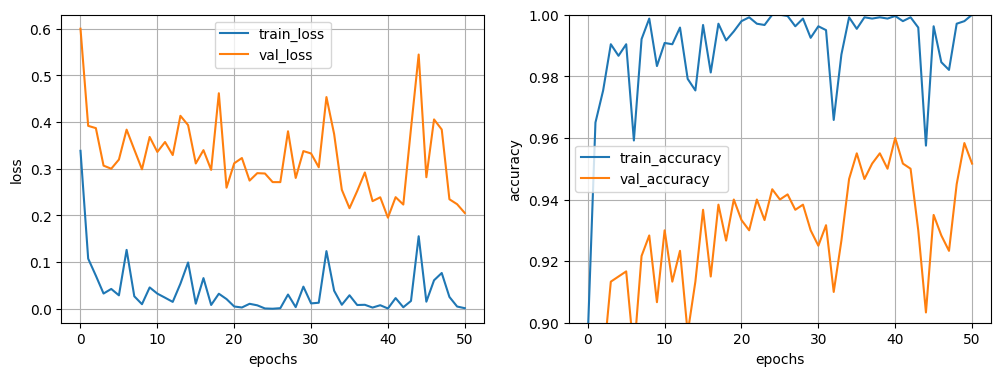

> loss: 0.1953, accuracy: 0.96
> loss: 0.03981, accuracy: 0.9917
CPU times: user 4h 19min 50s, sys: 5h 18min 30s, total: 9h 38min 20s
Wall time: 1h 3min 3s


In [ ]:
# %%time
# layer_params = {
#     'Conv1': {'channel': 64, 'size': 3, 'pad': 0, 'stride': 1},
#     'ReLU1': {},
#     'Conv2': {'channel': 64, 'size': 3, 'pad': 0, 'stride': 1},
#     'ReLU2': {},
#     'Pool1': {'size': 2, 'pad': 0, 'stride': 2},
#     'BatchNorm1': {},
#     # 'Dropout1': {'dropout': 0.1},
#     'Conv3': {'channel': 128, 'size': 3, 'pad': 0, 'stride': 1},
#     'ReLU3': {},
#     'Conv4': {'channel': 128, 'size': 3, 'pad': 0, 'stride': 1},
#     'ReLU4': {},
#     'Pool2': {'size': 2, 'pad': 0, 'stride': 2},
#     'BatchNorm2': {},
#     # 'Dropout2': {'dropout': 0.1},
#     'Conv5': {'channel': 256, 'size': 3, 'pad': 0, 'stride': 1},
#     'ReLU5': {},
#     'Pool3': {'size': 2, 'pad': 0, 'stride': 2},
#     'BatchNorm3': {},
#     # 'Dropout3': {'dropout': 0.1},
#     'Flatten': {},
#     'Affine1': {'hidden_size': 512},
#     'ReLU6': {},
#     'BatchNorm4': {},
#     'Affine2': {'hidden_size': 256},
#     'ReLU7': {},
#     'BatchNorm5': {},
#     'Affine3': {'hidden_size': 15},
# }
# hp_params = {
#     'layer_params': layer_params,
#     'learning_rate': 1e-3, 'epsilon': 1e-8, # Compile HP
#     'batch_size': 32, 'epochs': 100, 'patience': 10, # fit HP
# }
# model, history_df = trainConv2DNN(X_train, y_train, X_test, y_test, **hp_params)
# loss, accuracy = testModel(model, X_test, y_test)
# loss, accuracy = testModel(model, train_data, train_label)

## OPTUNA

### objective

In [23]:
# def objective(trial):
#     hp_params = {
#         # Conv2D HP
#         'conv2d_layers': trial.suggest_int('conv2d_layers', 1, 3), 
#         # Dense HP
#         'dense_layers': trial.suggest_int('dense_layers', 1, 8), 
#         # Compile HP
#         'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
#         'epsilon': trial.suggest_float('epsilon', 1e-9, 1e-3, log=True), 
#         # fit HP
#         'batch_size': trial.suggest_int('batch_size', 16, 512, step=16), 
#         'epochs': trial.suggest_int('epochs', 1000, 1000), 
#         'patience': trial.suggest_int('patience', 2, 32, step=2), 
#     }
#     # add conv2d hp
#     for conv2d_layer in range(1, hp_params['conv2d_layers']+1):
#         hp_params[f'conv2d_layer{conv2d_layer}_filters'] = trial.suggest_int(f'conv2d_layer{conv2d_layer}_filters', 16, 512, step=16)
#     # add dense hp
#     for dense_layer in range(1, hp_params['dense_layers']+1):
#         hp_params[f'dense_layer{dense_layer}_units'] = trial.suggest_int(f'dense_layer{dense_layer}_units', 16, 512, step=16)
#         hp_params[f'dense_layer{dense_layer}_dropout'] = trial.suggest_float(f'dense_layer{dense_layer}_dropout', 0.00, 0.50, step=0.1)
    
#     # print(hp_params)
    
#     model, history = trainConv2DNN(X_train, y_train, quite=True, **hp_params)
#     loss, accuracy = testModel(model, X_test, y_test, quite=True)
    
#     return accuracy

### study

In [24]:
# study = optuna.create_study(
#     storage = 'sqlite:///scrach_conv2dnn.db', 
#     sampler = optuna.samplers.TPESampler(seed=42), 
#     study_name = 'conv2dnn', 
#     direction = 'maximize',
#     load_if_exists = True,
# )

### optimize

In [25]:
# # initial value
# study.enqueue_trial({
#     'conv2d_layers': 1, 'conv2d_layer1_filters': 64, # Conv2D HP
#     'dense_layers': 1, 'dense_layer1_units': 128, 'dense_layer1_dropout': 0.1, # Dense HP
#     'learning_rate': 1e-3, 'epsilon': 1e-7, # Compile HP
#     'batch_size': 32, 'epochs': 1000, 'patience': 4, # fit HP
# })

In [26]:
# ### callback
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# def customCallback(study, trial):
#     previous_best_value = study.user_attrs.get('previous_best_value', None)
#     if previous_best_value != study.best_value:
#         study.set_user_attr('previous_best_value', study.best_value)
#         print(f'Trial {trial.number} finished with best value: {trial.value} and parameters: {trial.params}')

In [27]:
# study.optimize(
#     objective,
#     # n_trials = 10,
#     timeout=60*60*1,
#     callbacks=[customCallback]
# )

### check study

In [28]:
# study_df = study.trials_dataframe()
# study_df.sort_values('value', ascending=False).head()

In [29]:
# optuna.visualization.plot_optimization_history(study)

In [30]:
# optuna.visualization.plot_param_importances(study)

### get best params

In [31]:
# study.best_params

## Output

In [32]:
# with open("katakana_model.pickle", "wb") as f:
#     pickle.dump(model, f)

In [33]:
with open("katakana_model_params.pickle", "wb") as f:
    pickle.dump(model.params, f)
with open("katakana_model_bn_params.pickle", "wb") as f:
    pickle.dump(model.bn_params, f)
with open("katakana_model_hp_params.pickle", "wb") as f:
    pickle.dump(hp_params, f)

## Test

In [34]:
np.random.seed(42)
# create model
with open("katakana_model_hp_params.pickle", "rb") as f:
    temp_hp_params = pickle.load(f)
temp_model = Conv2DNN(
    input_dim=X_test.shape[1:], 
    weight_init_std=0.01,
    **temp_hp_params
)
temp_model.summary()
    
i = 0
# set params
with open("katakana_model_bn_params.pickle", "rb") as f:
    temp_bn_params = pickle.load(f)
with open("katakana_model_params.pickle", "rb") as f:
    temp_params = pickle.load(f)
for key in temp_hp_params['layer_params'].keys():
    if (
        ('Conv' in key) or ('Affine' in key)
    ):
        # print(i, key)
        temp_model.layers[key].W = temp_params[f'W{i}']
        temp_model.layers[key].b = temp_params[f'b{i}']
        i += 1
    elif ('BatchNorm' in key):
        temp_model.layers[key].gamma = temp_params[f'gamma{i}']
        temp_model.layers[key].beta = temp_params[f'beta{i}']
        temp_model.layers[key].moving_mean = temp_bn_params[f'moving_mean{i}']
        temp_model.layers[key].moving_var = temp_bn_params[f'moving_var{i}']
        i += 1

loss, accuracy = testModel(temp_model, X_test, y_test)
loss, accuracy = testModel(temp_model, train_data, train_label)

Conv1		(None, 64, 26, 26)	640	(64, 1, 3, 3), (64,)
Conv2		(None, 64, 24, 24)	36928	(64, 64, 3, 3), (64,)
Pool1		(None, 64, 12, 12)
BatchNorm1	(None, 64, 12, 12)	256	(64,), (64,), (64,), (64,)
Conv3		(None, 128, 10, 10)	73856	(128, 64, 3, 3), (128,)
Conv4		(None, 128, 8, 8)	147584	(128, 128, 3, 3), (128,)
Pool2		(None, 128, 4, 4)
BatchNorm2	(None, 128, 4, 4)	512	(128,), (128,), (128,), (128,)
Conv5		(None, 256, 2, 2)	295168	(256, 128, 3, 3), (256,)
Pool3		(None, 256, 1, 1)
BatchNorm3	(None, 256, 1, 1)	1024	(256,), (256,), (256,), (256,)
Flatten		(None, 256)
Affine1		(None, 512)		131584	(256, 512), (512,)
Affine2		(None, 15)		7695	(512, 15), (15,)
> loss: 0.2574, accuracy: 0.96
> loss: 0.05198, accuracy: 0.9917


In [35]:
i = 100
j = 132
# yy = model.predict(X_test[i:j], train_flg=False)
yy = temp_model.predict(X_test[i:j], train_flg=False)
yy = np.argmax(yy, axis=1)
print('yy', yy)
tt = y_test[i:j]
tt = np.argmax(tt, axis=1)
print('tt', tt)
np.sum(yy == tt) 

yy [12  6  3  0  6  6 13  0 12  8  7  7  7  3  7  0 10  5  6  2  2  4  1 10
  1 11 10  3 13 12  1 11]
tt [12  6  3  0  6  6 13  0 12  8  7  7  7  3  7  0 10  7  6  2  2  4  1 10
  1 11 10  3 13 12  1 11]


31